In [1]:
!git clone https://github.com/Khanhnvtb/Text-to-image

Cloning into 'Text-to-image'...
remote: Enumerating objects: 8214, done.
remote: Counting objects: 100% (2720/2720), done.
remote: Compressing objects: 100% (2717/2717), done.
remote: Total 8214 (delta 9), reused 2709 (delta 3), pack-reused 5494
Receiving objects: 100% (8214/8214), 1.01 GiB | 26.35 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Updating files: 100% (24/24), done.


In [2]:
%cd Text-to-image

/content/Text-to-image


In [3]:
!pip install pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 34.7 MB/s eta 0:00:00


In [62]:
import numpy as np
import pandas as pd
import keras
from keras.layers import *
from keras.callbacks import *
from keras.models import *
from keras.losses import *
from keras.optimizers import *
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from pyvi import ViTokenizer
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

X = train_df.drop(['label'], axis=1).values.reshape(-1, 28,28) / 255
y = train_df['label'].values

X_test = test_df.values.reshape(-1, 28,28) / 255

In [63]:
latent_input = Input(shape=(100,), name='latent_input')
label_input = Input(shape=(1,), name='label_input')
x = Embedding(input_dim=10, output_dim=10)(label_input)
x = Reshape((10,))(x)
x = concatenate([x, latent_input], axis=-1)
x = Dense(7*7*128)(x)
x = LeakyReLU()(x)
x = Reshape((7,7,128))(x)
x = UpSampling2D()(x)
x = Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = UpSampling2D()(x)
x = Conv2D(32, kernel_size=3, strides=1, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(1, kernel_size=3, strides=1, padding='same')(x)
x = Activation('sigmoid')(x)
x = Reshape((28,28,))(x)
generator = Model(inputs=[latent_input, label_input], outputs=x)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 label_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 10)        100         ['label_input[0][0]']            
                                                                                                  
 reshape (Reshape)              (None, 10)           0           ['embedding[0][0]']              
                                                                                                  
 latent_input (InputLayer)      [(None, 100)]        0           []                               
                                                                                              

In [64]:
img_input = Input(shape=(28,28,))
x = Reshape((28,28,1))(img_input)
x = Conv2D(16, kernel_size=3, strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(32, kernel_size=3, strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=3, strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(11, activation='softmax')(x)
discriminator = Model(inputs=img_input, outputs=x)
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 reshape_3 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 16)        0         
                                                                 
 batch_normalization_2 (Batc  (None, 14, 14, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 32)          4640      
                                                           

In [65]:
latent_input = Input(shape=(100,), name='latent_input')
label_input = Input(shape=(1,), name='label_input')
x = generator([latent_input, label_input])
x = discriminator(x)
gan = Model(inputs=[latent_input, label_input], outputs=x)
discriminator.trainable = False
gan.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 latent_input (InputLayer)      [(None, 100)]        0           []                               
                                                                                                  
 label_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 model (Functional)             (None, 28, 28)       789221      ['latent_input[0][0]',           
                                                                  'label_input[0][0]']            
                                                                                                  
 model_1 (Functional)           (None, 11)           103755      ['model[0][0]']            

In [66]:
discriminator.trainable = True
discriminator.compile(loss='sparse_categorical_crossentropy', metrics=['acc'], optimizer=Adam(0.001))
discriminator.trainable = False
gan.compile(loss='sparse_categorical_crossentropy', metrics=['acc'], optimizer=Adam(0.0003))

In [67]:
def random_mnist_set(X, y, size=10):
    length = len(X)
    indices = np.random.choice(length, size)
    return X[indices], y[indices]

def random_generated_set(generator, size=10):
    latents = np.random.normal(0, 1, (size, 100))
    return generator.predict_on_batch({'latent_input':latents,
                      'label_input':np.random.randint(10, size=size)})

In [68]:
save_interval = 300
epochs = save_interval*10+1
batch_size=20
history = {'dloss':[], 'gloss':[]}
for iteration in range(epochs):
    discriminator.trainable=True
    X_sample, y_sample = random_mnist_set(X, y, batch_size)
    dloss_real = discriminator.train_on_batch(X_sample, y_sample)
    dloss_fake = discriminator.train_on_batch(random_generated_set(generator, size=batch_size), np.full(batch_size, 10))

    discriminator.trainable=False

    gan_labels = np.random.randint(10, size=batch_size)
    gloss = gan.train_on_batch({'latent_input':np.random.normal(0, 1, (batch_size, 100)),
                        'label_input':gan_labels},
                       gan_labels)

    history['dloss'].append((dloss_real[0]+dloss_fake[0])/2)
    history['gloss'].append(gloss[0])
    if iteration % save_interval == 0:
        print('generator: loss={}. acc={}'.format(gloss[0], gloss[1]))
        print('discriminator: loss_real={}, acc_real={}'.format(dloss_real[0],dloss_real[1]))
        print('    loss_fake={}, acc_fake={}'.format(dloss_fake[0],dloss_fake[1]))
        generator.save_weights('generator_{0:05d}.h5'.format(iteration))

generator: loss=2.3982415199279785. acc=0.05000000074505806
discriminator: loss_real=3.296271562576294, acc_real=0.05000000074505806
    loss_fake=3.752805233001709, acc_fake=0.05000000074505806
generator: loss=1.8253158330917358. acc=0.3499999940395355
discriminator: loss_real=0.82551509141922, acc_real=0.8500000238418579
    loss_fake=0.01575915329158306, acc_fake=1.0
generator: loss=1.8678967952728271. acc=0.30000001192092896
discriminator: loss_real=0.12043962627649307, acc_real=0.949999988079071
    loss_fake=0.0003147645038552582, acc_fake=1.0
generator: loss=0.6434774398803711. acc=0.699999988079071
discriminator: loss_real=0.353611558675766, acc_real=0.8500000238418579
    loss_fake=0.02028241753578186, acc_fake=1.0
generator: loss=0.5412923693656921. acc=0.75
discriminator: loss_real=0.0487523227930069, acc_real=1.0
    loss_fake=0.0014797673793509603, acc_fake=1.0
generator: loss=0.13795185089111328. acc=0.8500000238418579
discriminator: loss_real=0.01616351678967476, acc_rea

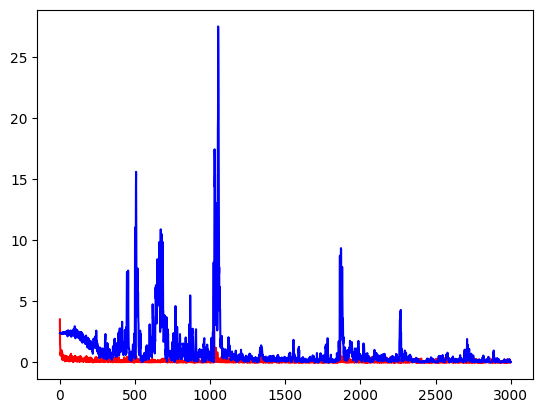

In [69]:
plt.plot(history['dloss'], 'r')
plt.plot(history['gloss'], 'b')

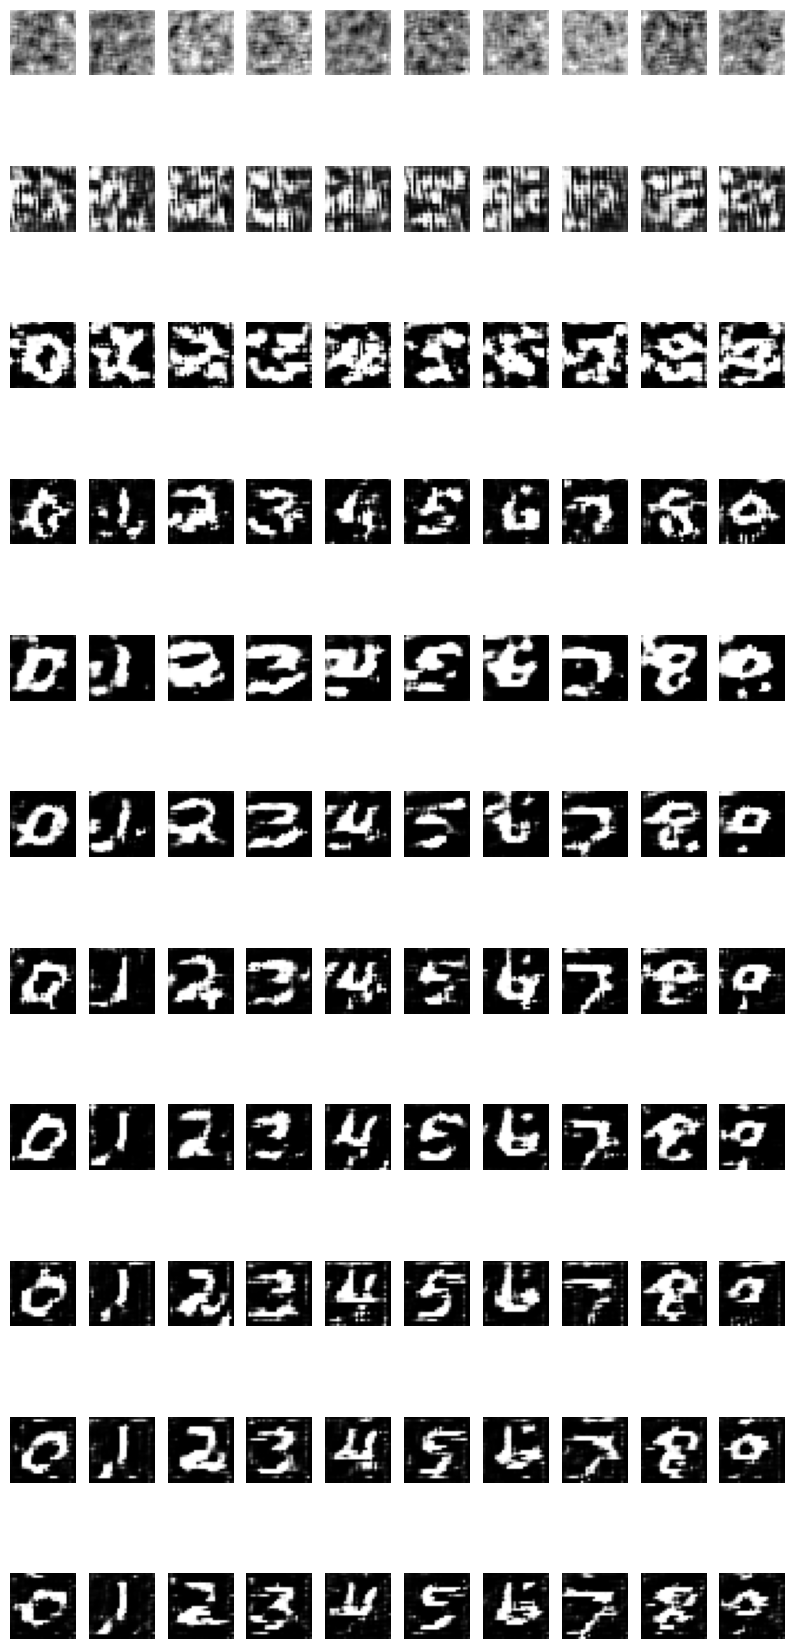

In [70]:
checkpoints = sorted(glob.glob('generator_*.h5'))

plt.figure(figsize=(10,2*len(checkpoints)))
for i,cp in enumerate(checkpoints):
    generator.load_weights(cp)
    generated = generator.predict_on_batch({'latent_input':np.random.normal(0, 1, (10, 100)),
                      'label_input':np.arange(10)})
    for j, g in enumerate(generated):
        plt.subplot(len(checkpoints),10,10*i+j+1)
        plt.imshow(g, cmap='gray')
        plt.axis('off')

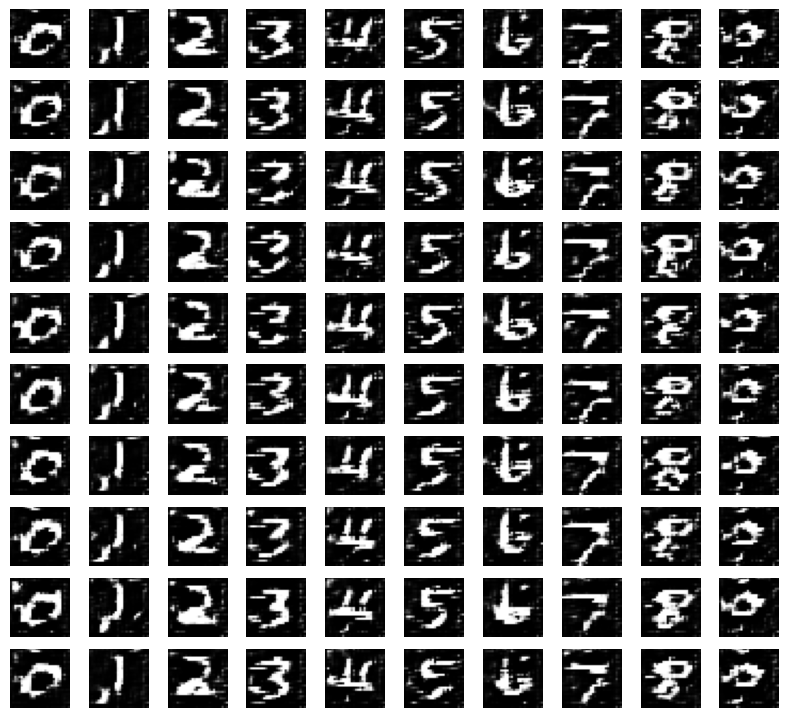

In [71]:
generator.load_weights(checkpoints[-1])
plt.figure(figsize=(10,10))
for i in range(10):
    generated = generator.predict_on_batch({'latent_input':np.random.normal(0, 1, (10, 100)),
                      'label_input':np.arange(10)})
    for j, g in enumerate(generated):
        plt.subplot(len(checkpoints),10,10*i+j+1)
        plt.imshow(g, cmap='gray')
        plt.axis('off')

In [72]:
generator.save('model_gan.h5')

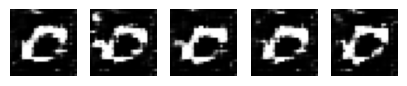

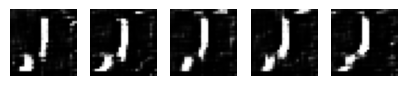

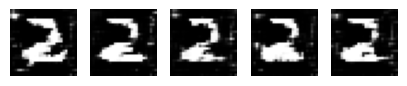

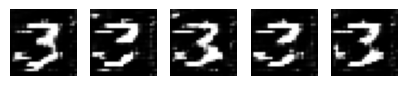

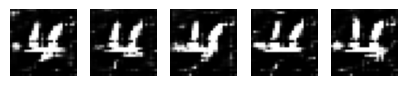

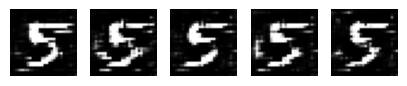

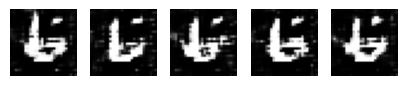

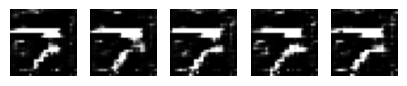

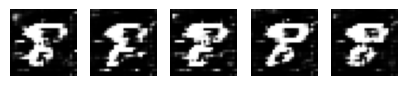

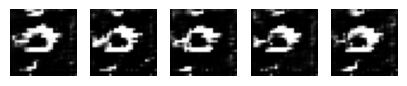

In [74]:
def get_image(generator, label, num_images=1):
    latent_samples = np.random.normal(0, 1, (num_images, 100))
    label_samples = np.full(num_images, label)
    generated_images = generator.predict_on_batch({'latent_input': latent_samples,
                                                   'label_input': label_samples})
    return generated_images

# Load the generator model
generator.load_weights('model_gan.h5')

for i in range(10):

    # Generate images with label 5
    label = i
    num_images = 5
    generated_images = get_image(generator, label, num_images)

    # Display the generated images
    plt.figure(figsize=(num_images, 1))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(generated_images[i], cmap='gray')
        plt.axis('off')
    plt.show()

In [5]:
df = pd.read_excel('data.xlsx')
df

,content,label
0,số tự nhiên nhỏ nhất,0
1,số chẵn nhỏ nhất không âm,0
2,số không âm nhỏ nhất,0
3,bội số nhỏ nhất của 2,0
4,số mà không thể là số chia của một phép chia,0
5,tổng của một số với số này đều bằng 0,0
6,tích của số này với tất cả các số đều bằng chí...,0
7,số mà chia hết được cho tất cả các số trừ chín...,0
8,số tự nhiên lẻ nhỏ nhất,1
9,mọi số nhân với số này đều bằng chính nó,1


In [9]:
for i in range(len(df)):
    df['content'][i] = ViTokenizer.tokenize(df['content'][i])
df.head()

<ipython-input-9-a9cfda6d6beb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content'][i] = ViTokenizer.tokenize(df['content'][i])


,content,label
0,số tự_nhiên nhỏ nhất,0
1,số_chẵn nhỏ nhất không âm,0
2,số không âm nhỏ nhất,0
3,bội_số nhỏ nhất của 2,0
4,số mà không_thể là số_chia của một_phép chia,0


In [10]:
X_train, y_train = df['content'], df['label']
X_train, y_train

(0                                  số tự_nhiên nhỏ nhất
 1                             số_chẵn nhỏ nhất không âm
 2                                  số không âm nhỏ nhất
 3                                 bội_số nhỏ nhất của 2
 4          số mà không_thể là số_chia của một_phép chia
 5                 tổng của một_số với số này đều bằng 0
 6     tích của số này với tất_cả các số đều bằng chí...
 7     số mà chia hết được cho tất_cả các số_trừ chín...
 8                               số tự_nhiên lẻ nhỏ nhất
 9              mọi số_nhân với số này đều bằng chính nó
 10             mọi số_chia cho số này đều bằng chính nó
 11                       mọi số đều chia hết cho số này
 12                             số_nguyên dương nhỏ nhất
 13                        số_nguyên dương chẵn nhỏ nhất
 14    tính chẵn của một_số được thể_hiện bằng phép c...
 15                                số_nguyên_tố nhỏ nhất
 16                                hệ nhị_phân là hệ mấy
 17    Số atomic của nguyên_tố 

In [11]:
vectorization = TfidfVectorizer()

X_train = vectorization.fit_transform(X_train)

joblib.dump(vectorization, open("tfidf.pkl", "wb"))

In [13]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [14]:
joblib.dump(model, 'model.joblib')

['model.joblib']

In [58]:
x_test = ['số tự nhiên nhỏ nhất', 'tính chẵn thể hiện qua phép chia cho mấy', 'số lớn nhất có một chữ số', 'một tuần có mấy ngày']
x_test = pd.DataFrame({'content': x_test})
x_test

,content
0,số tự nhiên nhỏ nhất
1,tính chẵn thể hiện qua phép chia cho mấy
2,số lớn nhất có một chữ số
3,một tuần có mấy ngày


In [59]:
x_test = vectorization.transform(x_test['content'])
x_test.shape

(4, 99)

In [60]:
model.predict(x_test)

array([0, 2, 9, 7])

In [95]:
latent_input = Input(shape=(100,), name='latent_input')
label_input = Input(shape=(1,), name='label_input')
x = Embedding(input_dim=10, output_dim=10)(label_input)
x = Reshape((10,))(x)
x = concatenate([x, latent_input], axis=-1)
x = Dense(7*7*128)(x)
x = LeakyReLU()(x)
x = Reshape((7,7,128))(x)
x = UpSampling2D()(x)
x = Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = UpSampling2D()(x)
x = Conv2D(32, kernel_size=3, strides=1, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(1, kernel_size=3, strides=1, padding='same')(x)
x = Activation('sigmoid')(x)
x = Reshape((28,28,))(x)
generator = Model(inputs=[latent_input, label_input], outputs=x)
gan_model = generator.load_weights('model_gan.h5')
rf_model = joblib.load('model.joblib')
vectorizer = joblib.load("tfidf.pkl", 'r')

def text_to_image(gan_model, rf_model, vectorizer, content, num_images=1):
    content = vectorizer.transform([content])
    if (max(rf_model.predict_proba(content)[0]) >= 0.8):
        latent_samples = np.random.normal(0, 1, (num_images, 100))
        label_samples = np.full(num_images, rf_model.predict(content)[0])
        generated_images = generator.predict_on_batch({'latent_input': latent_samples,
                                                    'label_input': label_samples})
    else:
        return 'Câu hỏi của bạn nằm ngoài khả năng trả lời của tôi'
    return generated_images

In [100]:
def show_images(images):
    plt.figure(figsize=(15, 5))  # Điều chỉnh kích thước lưới hình ảnh

    for i, image in enumerate(images):
        plt.subplot(1, len(images), i + 1)  # Dòng, cột, vị trí thứ i+1
        plt.imshow(image, cmap='gray')  # Hiển thị hình ảnh
        plt.axis('off')  # Tắt trục x, y

    plt.show()

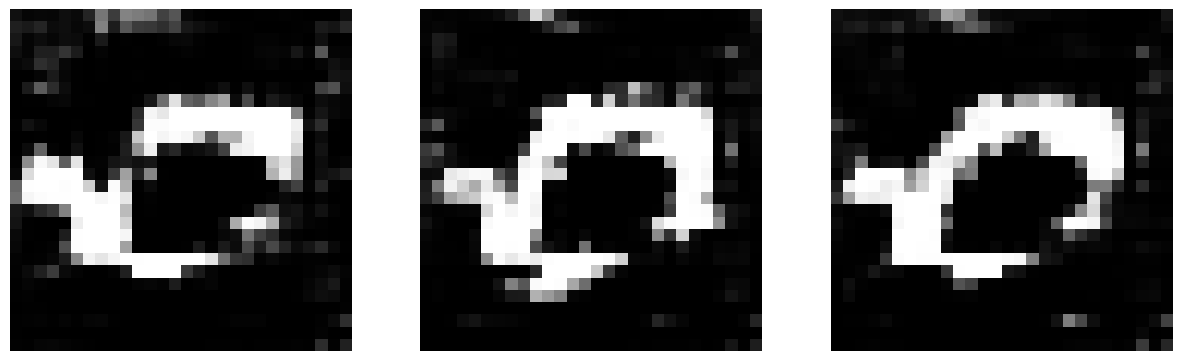

In [102]:
images = text_to_image(gan_model, rf_model, vectorizer, 'số tự nhiên nhỏ nhất', 3)
show_images(images)

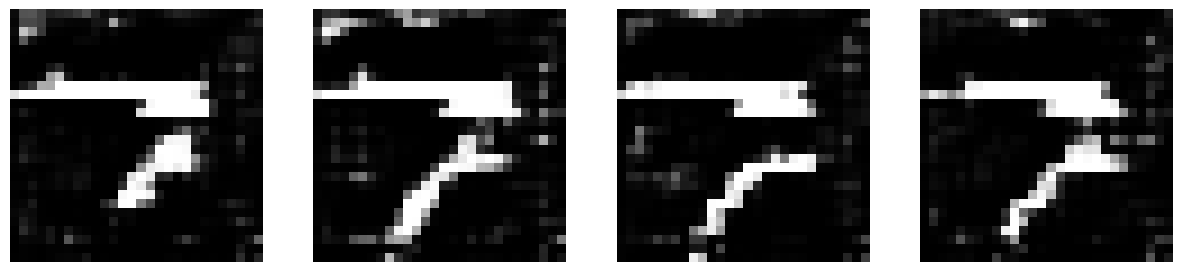

In [105]:
images = text_to_image(gan_model, rf_model, vectorizer, 'một tuần có mấy ngày', 4)
show_images(images)